In this assessment, you'll continue working with the houseprices data. To complete this assessment, at the end of this assessment submit a link to a Jupyter Notebook containing your solutions to the following tasks:

Load the houseprices data from Thinkful's database.
Reimplement your model from the previous lesson.
Try OLS, lasso, ridge, and elastic net regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

In [21]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine, text
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [8]:

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
#insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

house_prices_df = pd.DataFrame(engine.connect().execute(text('select * from houseprices')))

# No need for an open connection, because you're only doing a single query
engine.dispose()

house_prices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [3]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [4]:
from sklearn.model_selection import train_test_split
# Y is the target variable
Y = house_prices_df['saleprice']
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_FV', 'mszoning_RL'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))



The number of observations in training set is 1168
The number of observations in test set is 292


In [5]:
X_train.head()

,overallqual,grlivarea,garagecars,totalbsmtsf,mszoning_FV,mszoning_RL,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
151,5,969,2,969,0,1,0,0,1,0,1
262,8,2574,3,1482,0,1,0,0,1,0,1
1037,8,2263,2,1055,0,1,0,0,1,0,1
1183,5,1130,2,1120,0,1,0,0,1,0,1
933,7,1500,2,1500,0,1,0,0,1,0,1


In [6]:
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     424.9
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        02:41:11   Log-Likelihood:                -13973.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1158   BIC:                         2.802e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.005e+05   2.05e+04     -4.900      

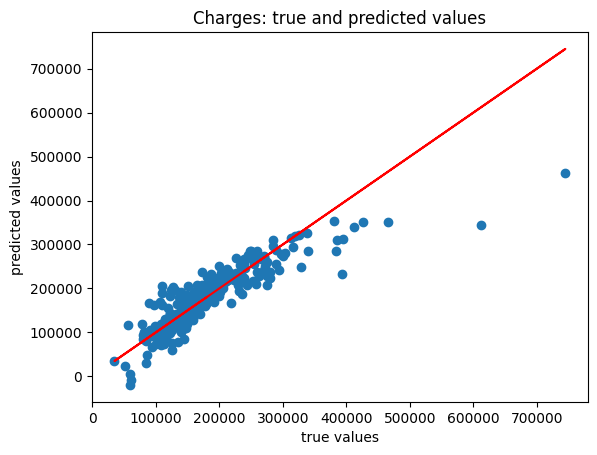

Mean absolute error of the prediction is: 25698.40029906949
Mean squared error of the prediction is: 1560222128.7468936
Root mean squared error of the prediction is: 39499.64719775221
Mean absolute percentage error of the prediction is: 15.66123355697912


In [9]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



**Try to improve your model in terms of predictive performance by adding or removing some variables**

In [10]:
from sklearn.model_selection import train_test_split

house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y1 = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X1 = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X1_train.shape[0]))
print("The number of observations in test set is {}".format(X1_test.shape[0]))



The number of observations in training set is 1168
The number of observations in test set is 292


In [ ]:
X1_train.head()

,overallqual,grlivarea,garagecars,garagearea,totalsf,int_over_sf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
151,5,969,2,440,1938,9690,0,0,1,0,1
262,8,2574,3,868,4056,32448,0,0,1,0,1
1037,8,2263,2,905,3318,26544,0,0,1,0,1
1183,5,1130,2,720,2250,11250,0,0,1,0,1
933,7,1500,2,570,3000,21000,0,0,1,0,1


In [11]:
X1_train = sm.add_constant(X1_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y1_train, X1_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     520.9
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        02:45:30   Log-Likelihood:                 463.99
No. Observations:                1168   AIC:                            -904.0
Df Residuals:                    1156   BIC:                            -843.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.9162      0.102     97.518      

This second model's R-squared and adjusted R-squared values are higher and AIC and BIC criterias are lower than the first model. In any case, these indicate that the second model has a better goodness of fit than the first model. Now, let's evaluate the test set performance of this second model:

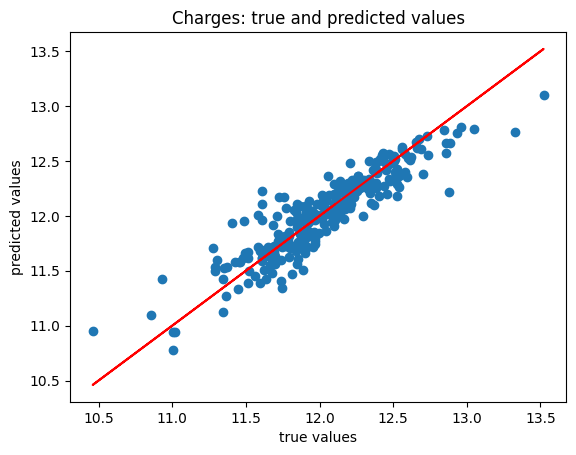

Mean absolute error of the prediction is: 0.12570372872852303
Mean squared error of the prediction is: 0.029192121871290135
Root mean squared error of the prediction is: 0.1708570217207655
Mean absolute percentage error of the prediction is: 1.0503577667817643


In [12]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# Add a constant to the model because it's best practice
# to do so every time!
X1_test = sm.add_constant(X1_test)

# You are making predictions here
y1_preds = results.predict(X1_test)

plt.scatter(y1_test, y1_preds)
plt.plot(y1_test, y1_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds) / y1_test)) * 100))



The test set evaluation metrics are given above. For every metric, the second model achieves a better prediction performance in the test set.

In [1]:
######### Not working -- so using Ridge cv by referring google #########
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Here, `alpha` is the regularization
# parameter (usually called `lambda`). As `alpha` gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37)
ridgeregr.fit(X_train, y_train)


# You are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

######### Not working -- so using Ridge cv by referring google #########

NameError: ignored

1.0
[1.54485909e+09 1.54485907e+09 1.54485890e+09 1.54485714e+09
 1.54483960e+09 1.54467309e+09 1.54408470e+09 1.54357438e+09]
R2:0.768, MSE:1560359463.13, RMSE:39501.39


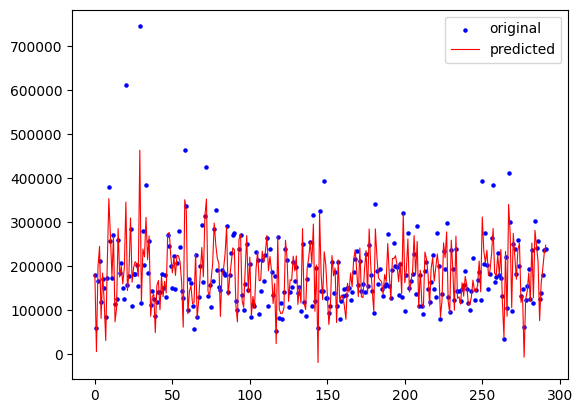

In [23]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1,0.5, 1]

# RidgeCV method
ridge_cv=RidgeCV(alphas=alphas, store_cv_values=True)
ridge_mod = ridge_cv.fit(X_train,y_train)
print(ridge_mod.alpha_)
print(np.mean(ridge_mod.cv_values_, axis=0))

ypred = ridge_mod.predict(X_test)
score = ridge_mod.score(X_test,y_test)
mse = mean_squared_error(y_test,ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
   .format(score, mse, np.sqrt(mse)))

x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [14]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5)
lassoregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.001618340746328606
Mean absolute error of the prediction is: 58023.64411709514
Mean squared error of the prediction is: 6724569139.943377
Root mean squared error of the prediction is: 82003.47029207592
Mean absolute percentage error of the prediction is: 36.65964810134902


In [15]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5)
lassoregr.fit(X1_train, y1_train)

# You are making predictions here
y1_preds_train = lassoregr.predict(X1_train)
y1_preds_test = lassoregr.predict(X1_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X1_train, y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X1_test, y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds_test) / y1_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.31782438122584333
Mean squared error of the prediction is: 0.16696763481899562
Root mean squared error of the prediction is: 0.40861673340551735
Mean absolute percentage error of the prediction is: 2.643764822133737


In [26]:
## not working ############3
from sklearn.linear_model import Lasso, LassoCV

alphas = [0.1,0.3, 0.5, 0.8, 1]
lassocv = LassoCV(alphas=alphas, cv=5).fit(X1_train,y1_test)
print(lassocv)
score = lassocv.score(X1_train,y1_test)
ypred = lassocv.predict(X1_test)
mse = mean_squared_error(y1_test,ypred)
print("Alpha:{0:.2f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(lassocv.alpha_, score, mse, np.sqrt(mse)))

x_ax = range(len(X1_test))
plt.scatter(x_ax, y1_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()


ValueError: ignored

0.01
-99956.32805901498
R2:0.768, MSE:1558789794.28, RMSE:39481.51


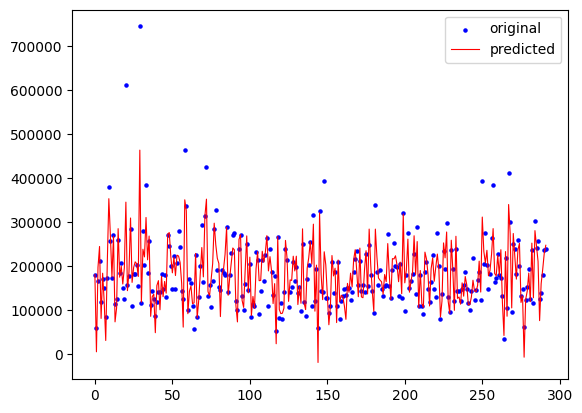

In [28]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

# --- ElasticNetCV ----
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
model = elastic_cv.fit(X_train, y_train)
print(model.alpha_)
print(model.intercept_)

ypred = model.predict(X_test)
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))

x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

0.001
10.056477030725937
R2:0.815, MSE:0.03, RMSE:0.18


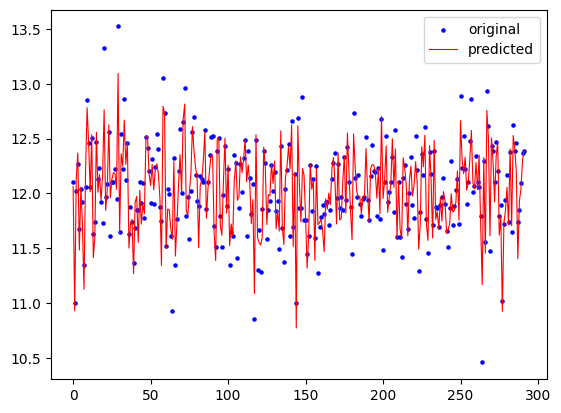

In [27]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

# --- ElasticNetCV ----
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
model = elastic_cv.fit(X1_train, y1_train)
print(model.alpha_)
print(model.intercept_)

ypred = model.predict(X1_test)
score = model.score(X1_test, y1_test)
mse = mean_squared_error(y1_test, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))

x_ax = range(len(X1_test))
plt.scatter(x_ax, y1_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

Reference solution for future use:https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/7.solution_overfitting_and_regularization.ipynb

In [30]:
#Copying the example sample solution for future reference
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine,text
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
#insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

house_prices_df = pd.DataFrame(engine.connect().execute(text('select * from houseprices')))

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [31]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.832132255313275
-----Test set statistics-----
R-squared of the model in test set is: 0.8249302330916467
Mean absolute error of the prediction is: 0.12570372872861488
Mean squared error of the prediction is: 0.029192121871356388
Root mean squared error of the prediction is: 0.17085702172095937
Mean absolute percentage error of the prediction is: 1.0503577667823578


In [34]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.831939428704242
-----Test set statistics-----
R-squared of the model in test set is: 0.8226434437869414
Mean absolute error of the prediction is: 0.12624310826908405
Mean squared error of the prediction is: 0.029573434037677006
Root mean squared error of the prediction is: 0.17196928225028157
Mean absolute percentage error of the prediction is: 1.0552354946577738


In [35]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8316364867222639
-----Test set statistics-----
R-squared of the model in test set is: 0.8203050076234288
Mean absolute error of the prediction is: 0.1267363733974104
Mean squared error of the prediction is: 0.02996335809297881
Root mean squared error of the prediction is: 0.17309927236409403
Mean absolute percentage error of the prediction is: 1.059694123031065


In [36]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 0.001
R-squared of the model in training set is: 0.8299654806803802
-----Test set statistics-----
R-squared of the model in test set is: 0.8149185869526184
Mean absolute error of the prediction is: 0.12770726087011364
Mean squared error of the prediction is: 0.030861520302533838
Root mean squared error of the prediction is: 0.17567447254092963
Mean absolute percentage error of the prediction is: 1.0685444897303118


According to the results, the best model is the OLS regression.